In [1]:
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# needed methods
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [6]:
X2D_using_svd = X2D

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [8]:
X3D_inv = pca.inverse_transform(X2D)

In [9]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [10]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [11]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [12]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

머신러닝 문제는 훈련 샘플이 각각 수천 수백만 개의 특성을 갖고 있기도 하다. 이런 많은 특성들은 훈련을 느리게 할 뿔만 아니라, 좋은 솔루션을 찾기 어렵게 만든다. 이런 문제를 **차원의 저주**라고 한다.

하지만 실제로는 정보를 잃지 않는 선에서 특성 수를 크게 줄여서 가능한 범위로 변경할 수 있는 경우가 많다. \
훈련 속도를 높이는 것 외에 차원 축소는 데이터 시각화에도 유용하다. 차원 수를 둘로 줄이면 고차원 훈련 세트를 하나의 압축된 그래프로 그릴 수 있고 군집 같은 시각적인 패턴을 감지해 중요한 통찰을 얻는 경우가 많다.

# 1. 차원의 저주
1,000차원의 공간에서 휘어져있는 200차원의 타원체를 상상할 수 있는가? 우리는 4차원 초입방체 조차 머리속에 그리기 어렵다. \
고차원 공간에선 많은 것이 다르게 동작한다. 예를 들어 단위면적(1x1) 사각형 안에 있는 점을 무작위로 선택한다면 경계선에서 0.001 이내에 위치할 가능성은 0.4%이다. 하지만 10,000차원의 단위 면적을 가진 초입방체에서는 99.9999%보다 커진다. \
또한 단위 면적에서 임의의 두 점을 선택하면 두 점 사이의 거리는 평균적으로 대략 0.52가 된다. 1,000,000차원의 초입방체에서는 평균 거리는 408.25가 된다. 

두 점이 단위 초입방체에 같이 놓여 있는데 왜 멀리 떨어져 있는 이유는 고차원은 많은 공간을 갖고 있기 때문이다. 이로 인해 고차원 데이터셋은 대부분의 훈련 데이터가 서로 멀리 떨어져 있다. 이는 새로운 샘플도 마찬가지일 확률이 높다는 것이다. 이 경우 예측을 위해 훨씬 많은 외삽(extrapolation)을 해야하므로 저차원보다 예측이 불안정하다.

이론적인 해결법으로는 훈련 샘플의 밀도가 높아질 때까지 훈련 세트의 크기를 키우는 것이다. 하지만 실제로는 일정 밀도에 도달하기 위해 필요한 훈련 샘플 수는 차원 수가 커짐에 따라 기하급수적으로 증가한다.

# 2. 차원 축소를 위한 접근 
차원을 감소시키는 두 가지 주요한 접근법인 투영과 매니폴드 학습을 알아본다.

## 2-1. 투영
대부분의 실전 문제는 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않다. 결과적으론 모든 훈련 샘플이 고차원 공간 안의 저차원 부분 공간에에 놓여 있다. 

Saving figure dataset_3d_plot


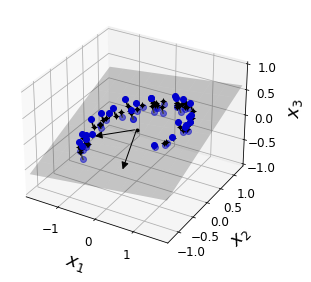

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("dataset_3d_plot")
plt.show()

예를 들어 위의 사진에서 원 모양을 띤 3차원 데이터셋이 있다. 모든 훈련 샘플이 거의 평면 형태로 놓여 있다. 이것은 3D 공간에 있는 2D 부분 공간이다. 여기서 모든 훈련 샘플을 이 부분 공간에 수직으로 투영하면 

Saving figure dataset_2d_plot


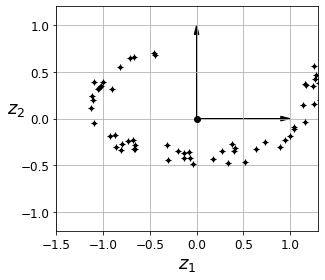

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

위와 같은 2D 데이터셋을 얻는다. 각 축은 새로운 특성 $z_1$과 $z_2$에 대응된다. 

그러나 차원 축소에 있어서 투영이 언제나 최선의 방법은 아니다. 많은 경우 아래에 표현된 스위스 롤 데이터셋처럼 부분 공간이 뒤틀리거나 휘어있기도 하다.

Saving figure swiss_roll_plot


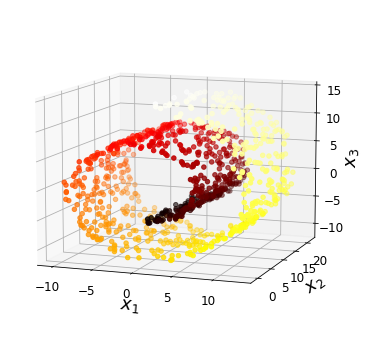

In [15]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

위의 스위스 롤 데이터셋을 평면에 투영 시키면 아래 사진의 왼쪽처럼 스위스 롤의 층이 서로 뭉개진다. \
하지만 원하는 것은 오른쪽처럼 2D 데이터셋을 얻는 것이다. 

Saving figure squished_swiss_roll_plot


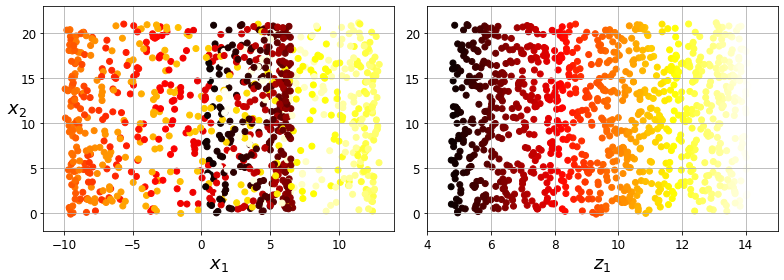

In [16]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

## 2-2. 매니폴드 학습

스위스 롤은 2D 매니폴드의 한 예다. 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양이다. 일반적으로 d차원 매니폴드는 국부적으로 d차원 초평면으로 보일 수 있는 n차원 공간의 일부이다(d < n). 스위스 롤의 경우 d=2이고 n=3이다. 국부적으로는 2D 평면으로 보이지만 3D로 말려 있다. 

많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 식으로 작동한다. 이를 **매니폴드 학습**이라고 한다.이는 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 **매니폴드 가정(가설)** 에 근거한다.

매니폴드 가정은 처리해야 할 작업이 저차원의 매니폴드 공간에 표현되면 간단해질 것이라는 가정과 병행되기도 한다. 예를 들어

Saving figure manifold_decision_boundary_plot1


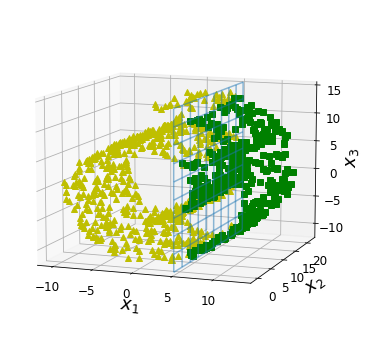

Saving figure manifold_decision_boundary_plot2


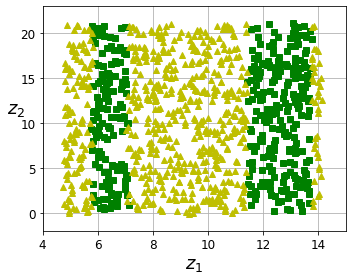

Saving figure manifold_decision_boundary_plot3


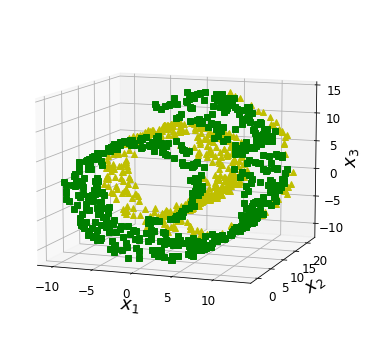

Saving figure manifold_decision_boundary_plot4


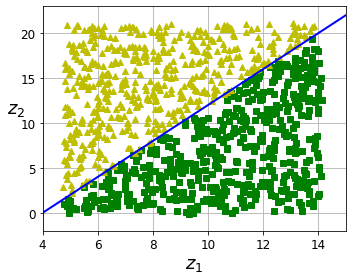

In [17]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

위 그림의 3번째 plot에서는 결정 경계가 복잡하지만, 4번째 plot은 단순한 직선이다. \
하지만 이런 암묵적인 가정이 항상 유효하진 않다. 1번째 사진에서는 결정 경계가 $x_1=a5$에 놓여 있다. 이는 3D공간에서는 단순하지만 2번째 사진인 2D에서 보면 복잡해졌다.

결국 모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아니다.

# 3. PCA
**주성분 분석(principal component analysis, PCA)** 은 많이 사용되는 차원축소 알고리즘이다.

## 3-1. 분산 보존
저차원의 초평면에 훈련 세트를 투영하기 전에 올바른 초평면을 선택해야 한다. 

Saving figure pca_best_projection_plot


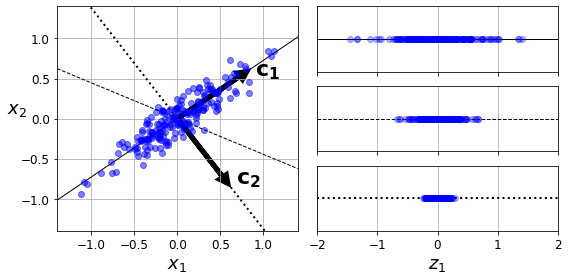

In [18]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

예를 들어 위 그림의 왼쪽 plot은 간단한 2D 데이터셋이 세 개의 축과 함께 표현되어 있다. 오른쪽 plot은 데이터셋이 각 축에 투영된 결과이다. 위에서 볼 수 있듯, 실선에 투영된 것은 분산을 최대로 보존하는 반면, 점선에 투영된 것은 분산을 매우 적게 유지한다. 가운데 파선에 투영된 것은 분산을 중간 정도로 유지하고 있다.

다른 방향으로 투영하기보단 분산이 최대로 보존되는 축을 선택하는 것이 정보가 최대한 적게 손실된다. 축은 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 선택한다.

## 3-2. 주성분

PCA는 훈련 세트에서 분산이 최대인 축을 찾는다. (위의 그림에서는 실선을 의미) 또한 첫 번째 축에 직교하고 남은 분산을 최대한 보존하는 두 번째 축을 찾는다(점선). 데이터셋의 차원이 높아질수록 PCA는 이전의 축에 직교하는 n번째 축을 찾는다. 

i번째 축을 이 데이터의 i번째 **주성분(principan component, PC)** 이라고 부른다. 

주성분을 어떻게 찾을까? 표준 행렬 분해 알고리즘, 특잇값 분해(SVD)를 사용해서 훈련 세트 행렬 X를 세 개 행렬의 행렬곱인 $U\Sigma V^T$로 분해할 수 있다. 여기에 찾고자 하는 모든 주성분의 단위 벡터가 V에 
$V=\begin{pmatrix} 
c_1c_2\dots c_n 
\end{pmatrix}$와 같이 담겨있다.

아래 코드는 넘파이의 svd() 함수를 사용해 훈련 세트의 주성분을 구한 후 처음 두 개의 PC를 정의하는 두 개의 단위 벡터를 추출한다.

In [19]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,  0]
c2 = Vt.T[:, 1]

print(c1, c2)

[-0.79644131 -0.60471583] [-0.60471583  0.79644131]


## 3-3. d차원으로 투영

주성분을 전부 추출했다면 처음 d개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원으로 축소시킬 수 있다. 이 초평면은 분산을 최대로 보존하는 투영이다.

초평면에 훈련 세트를 투영하고 d차원으로 축소된 데이터셋 $X^{d-proj}$을 얻기 위해 행렬 X와 V의 첫 d열로 구성된 행렬 $W_b$를 행렬 곱셈하면 된다.

$X_{d-proj}=XW_d$

아래의 코드는 첫 두개의 주성분으로 정의된 평면에 훈련 세트를 투영한다.

In [20]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)

## 3-4. Sklearn PCA
사이킷런의 PCA 모델은 SVD 분해 방법을 사용하여 구현한다. 

아래 코드는 PCA모델을 이용해서 데이터셋의 차원을 2차원으로 줄이는 코드이다.

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

PCA 변환기를 데이터셋에 학습시키면 components_ 속성에 $W^d$의 전치가 담겨 있다. 

## 3-5. 설명된 분산의 비율
explained_variance_ratio_ 변수에 저장된 주성분의 **설명된 분산의 비율(explained variance ratio)** 도 유용한 정보이다. 이 비율은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다. 

In [22]:
pca.explained_variance_ratio_

array([0.95369864, 0.04630136])

이는 데이터셋 분산의 95.3%가량이 첫 번째 PC를 따라 놓여있고, 4.6%가량이 두 번째 PC를 따라 놓여 있음을 뜻한다. PC3에는 아주 적은 양의 정보가 들어있을 것이다. 

## 3-6. 적절한 차원 수 선
축소할 차원 수를 임의로 정하기 보다는 충분한 분산이 될 때까지 더해야할 차원 수를 선택하는 것이 간단하다. 

아래 코드는 차원을 축소하기 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는데 필요한 최소한의 차원 수를 계산한다.

In [23]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [25]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_reduced

array([[1540.00356811,   31.93937218, -429.97321065, ...,  -84.65004103,
           6.74294682,   20.47482278],
       [-147.85255021,  195.96359846,  -88.79927091, ...,   15.71573594,
         -63.52459544,    7.75944697],
       [ 197.87826738,   73.97047035,  331.97279157, ...,  -23.3617457 ,
          36.31976347,   23.69626902],
       ...,
       [-388.19280532,  758.17127529,  286.00242737, ...,  -13.22716805,
         -17.03272723,  -47.12905142],
       [-392.25807025, -279.30961495,  -76.99133604, ...,   23.26272928,
          88.79718425,   40.25487363],
       [-184.53517546,  499.90421879, -543.43716389, ...,   64.58401628,
         -31.17769535,   52.65581497]])

설명된 분산을 차원 수에 대한 함수로 그리는 방법도 있다. 즉, cumsum을 그래프로 그린다.

Saving figure explained_variance_plot


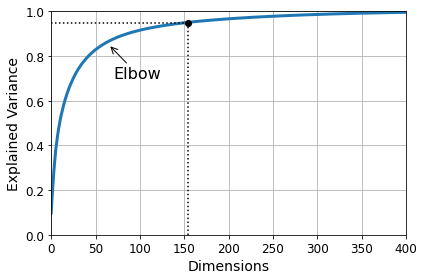

In [26]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

위 그래프에는 설명된 분산의 빠른 성장이 멈추는 변곡점이 있다.

### 3-7. 압축을 위한 PCA

차원을 축소하고 난 후엔 훈련 세트의 크기가 줄어든다. 

예를 들어 MNIST 데이터셋에 분산의 95%를 유지하도록 PCA를 적용해본다. 

In [27]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [28]:
pca.n_components_

154

각 샘플은 154개의 특성을 갖고 있다. 데이터셋은 원본 크기의 20% 미만이 되엇다. 이렇게 압축되면 분류 알고리즘의 속도를 크게 높일 수 있다.

또한 압축된 데이터셋에 PCA 투영의 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수도 있다. 투영에서 일정량의 정보를 잃어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없다. 하지만 원본 데이터와 비슷하다. 원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리를 **재구성 오차(reconstruction error)** 라고 한다.

아래 코드는 MNIST 데이터셋을 154차원으로 압축하고 inverse_transform() 매서드를 사용해 784차원으로 복원한다.

In [29]:
pca = PCA(n_components = 154)
X_reduce = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [30]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


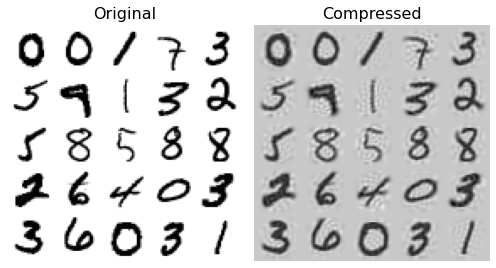

In [31]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original', fontsize=16)

plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title('Compressed', fontsize=16)

save_fig('mnist_compression_plot')

위의 사진은 원본 훈련 세트와 샘플을 압축한 후 복원한 결과를 보여준다. 

역변환 공식 \
$X_{recoveredd}=X_{d-proj}W^T_d$

## 3-8. 랜덤 PCA

svd_solver 매개변수를  'randomized'로 지정하면 사이킷런은 random PCA라 부르는 확률적 알고리즘을 사용해 처음 d개의 주성분에 대한 근사값을 빠르게 찾는다. 이 알고리즘의 계산 복잡도는 $O(m\times d^2)+O(d^3)$이다. 따라서 d < n의 경우 SVD보다 빠르다.

In [32]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

X_reduced

array([[1540.0035681 ,   31.93937215, -429.97321064, ...,   84.72912071,
         -19.75570201,  -58.36838997],
       [-147.85255022,  195.9635985 ,  -88.79927094, ...,  -12.16767366,
          55.34103007,  -12.49470948],
       [ 197.87826738,   73.97047034,  331.97279155, ...,   10.80010679,
         -82.47411708,   50.19128075],
       ...,
       [-388.19280531,  758.17127532,  286.00242738, ...,   16.3968888 ,
         -14.37370038,   -9.20630827],
       [-392.25807027, -279.30961504,  -76.99133602, ...,   -2.8879279 ,
         -86.85631185,  -53.89782911],
       [-184.53517548,  499.90421878, -543.43716392, ...,  -46.58098071,
          46.13137787,   46.6581297 ]])

svd_solver의 기본값은 'auto'이다 m, n이 500보다 크고 d가 m이나 n의 80%보다 작으면 sklearn은 자동으로 random PCA 알고리즘을 사용한다. sklearn에서 완전한 SVD 방식을 강제하려면 svd_solver 매개변수를 'full'로 지정한다.

# 3-9. 점진적 PCA

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것이다. **점진적 PCA(incremental PCA)(IPCA)** 알고리즘은 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입한다. 이런 방식은 훈련 세트가 클 때 유용하다.

다음 코드는 MNIST 데이터셋을 100개의 미니배치로 나누고 사이킷런의 IncrementalPCA 클래스를 이용하여 MNIST 데이터셋의 차원을 154개로 줄인다. partial_fit() 메서드를 미니배치마다 호출한다.

In [33]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

또 다른 방법은 넘파이의 memmap 클래스를 사용해 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것처럼 다루는 것이다. IncrementalPCA는 특정 순간에 배열의 일부만 사용하기 때문에 메모리 부족 문제를 해결할 수 있다(이 방식은 fit() 메서드를 사용할 수 있다.).

In [34]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [35]:
del X_mm

In [36]:
X_mm = np.memmap(filename, dtype ='float32', mode='readonly', shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [37]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [38]:
X_reduced

array([[ 1.54000357e+03,  3.19393722e+01, -4.29973211e+02, ...,
        -2.52469737e+01,  8.24747796e+01, -2.51765108e+01],
       [-1.47852550e+02,  1.95963598e+02, -8.87992708e+01, ...,
         9.84413376e+00,  3.09937565e+00, -4.47945209e-01],
       [ 1.97878267e+02,  7.39704704e+01,  3.31972792e+02, ...,
        -5.22205587e+01, -5.36367547e+01, -8.58820597e+00],
       ...,
       [-3.88192805e+02,  7.58171275e+02,  2.86002427e+02, ...,
         3.67804824e+01, -5.03650715e+01,  1.08751962e+01],
       [-3.92258070e+02, -2.79309615e+02, -7.69913359e+01, ...,
        -7.35697758e+01, -1.46167140e+01,  1.56668295e+01],
       [-1.84535175e+02,  4.99904219e+02, -5.43437164e+02, ...,
        -2.68781092e+01, -5.08687371e+01,  1.29284609e+01]])

# 4. 커널 PCA (KPCA)

커널 트릭을 PCA에 적용해 차원 축소를 위한 복잡한 비선형 투형을 수행할 수 있다. 이를 KPCA라고 한다. 이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 떄도 유용하다.

아래 코드는 sklearn의 KernelPCA를 사용해 RBF 커널로 KPCA를 적용한다.

In [39]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [40]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


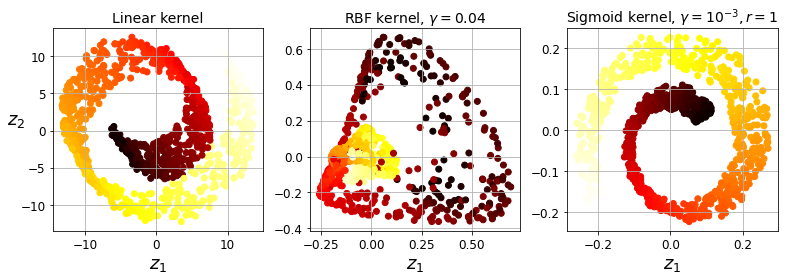

In [41]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

선형 커널, RBF 커널, 시그모이드 커널을 사용하여 2차원으로 축소시킨 스위스 롤이다. 

## 4-1. 커널 선택과 하이퍼파라미터 튜닝

KPCA는 비지도 학습이므로 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없지만 차원 축소는 학습의 전처리 단계로도 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있다.

아래 코드는 두 단계의 파이프라인을 만드는데, KPCA를 사용해 2차원으로축소하고 분류를 위해 로지스틱 회귀를 적용한다. 그 뒤 높은 분류 정확도를 위해 GridSearchCV를 사용한다.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

가장 좋은 커널과 하이퍼파라미터는 best_params_ 변수에 저장된다.

In [43]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


# 5. LLE
**지역 선형 임베딩(LLE)** 은 비선형 차원 축소(nonlinear dimentsionality reduction, NLDR) 알고리즘이다. 투영에 의존하지 않고, 매니폴드 학습이다. \
LLE는 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연과노디어 있는지 측정한다. 그 뒤 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾는다. 

아래 코드는 sklearn의 LocallyLinearEmbedding을 사용해 스위스 롤을 펼친다.

In [44]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [45]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


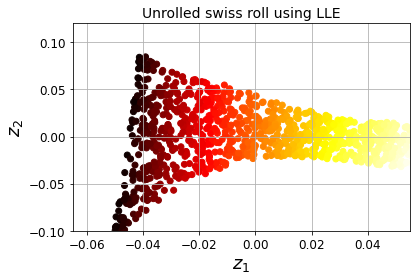

In [46]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()


결과를 보면 스위스 롤이 완전히 펼쳐졌다. 하지만 크게 보면 샘플 간 거리가 잘 유지되어 있지 않다. 펼쳐진 스위스 롤의 오른쪽은 압축되어 있고 왼쪽은 확장되어 있다. 

LLE는 알고리즘이 각 훈련 샘플 $x^{(i)}$에 대해 가장 가까운 k개의 샘플을 찾고, 이 이웃에 대한 선형 함수로 $x^{(i)}$로 재구성한다($x^{(i)}$와 $\sum^m_{j=1}w_{i,j}x^{(j)}$ 사이의 제곱 거리가 최소가 되는 $w_{i,j}$를 찾는 것이다.) \
여기서 $x^{(j)}$가 $x^{(i)}$의 가장 가까운 k개 이웃 중 하나가 아닌 경우 $w_{i,j}=0$이 된다. 그러므로 LLE의 첫 단계는 아래의 수식과 같은 제한이 있는 최적화 문제가 된다. 

$\hat W = \text{argmin}_w\sum^m_{j=1}(x^{(i)}-\sum^m_{j=1}w_{i,j}x^{(j)})^2$ \

[조건] 
$\begin{cases}
w_{i,j}=0 & \mbox{When } x^{(j)} \mbox{ is not one of } x^{(i)} \mbox{'s nearest k neighbors} \\
\sum^m_{j=1}w_{i,j} & i=1,2,\dots, m
\end{cases}$

위 단계를 거치면 가중치 행렬 $\hat W$은 훈련 샘플 사이에 잇는 지역 선형 관계를 담게 된다.

두 번째 단계는 d차원 공간으로 훈련 샘플을 매핑하는 것이다. 만약 $z^{(i)}$가 d차원 공간에서 $x^{(i)}$의  이미지라면 가능한 한 $z^{(i)}$와 $\sum^m_{j=1}w_{i,j} \hat w_{i,j}z^{(j)}$사이의 거리가 최소화 되어야 한다. 이 아이디어는 아래 수식과 같은 제약이 없는 최적화 문제로 바꿔준다. 이는 가중치를 고정하고 저차원의 공간에서 샘플 이미지의 최적 위치를 찾는다. 

$Z = argmin_z\sum^m_j=1(z^{(i)}-\sum^m_{j=1}\hat w_{i,j}z^{}(j))^2$
- Z =  $z^{(ㅑ)}$를 포함하는 행렬

LEE 구현의 계산 복잡도는 k개의 가장 가까운 이웃을 찾는 데 $O(m log(m)n log(k))$, 가중치 최적화에 $O(mnk^3)$, 저차원 표현을 만드는데 $O(dm^2)$이다. 때문에 대량의 데이터셋에 적용하기에는 어렵다.

# 6. 다른 차원 축소 기법

- 랜덤 투영 \
랜덤한 선형 투영을 사용해, 데이터를 저차원 공간으로 투영한다.
- 다차원 스케일링
샘플 간의 거리를 보존하면서 차원을 축소한다.
- isomap
각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만든다. 샘플 간의 지오데식 거리를 유지하며 차원을 축소한다.
- t-SNE
비슷한 샘플일 수록 가까이 두며 차원을 축소한다. 주로 시각화에 사용되며 고차원 공간에 있는 샘플의 군집을 시각화할 때 사용된다.
- 선형 판별 분석(Linear Discriminant Analysis, LDA)
훈련 과정에서 크래스 사이를 가장 잘 구분하는 축을 학습한다. (이 축은 데이터가 투영되는 초평면을 정의하는 데 사용한다.) 이 알고리즘의 장점은 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM 분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소시키는 데 좋다.